<a href="https://colab.research.google.com/github/milenoepifanio/Exploratorio_Titanic/blob/main/ML_Titanic_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
teste = pd.read_csv('/content/test.csv')
teste.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [ ]:
treino = pd.read_csv('/content/train.csv')
treino.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [ ]:
#Eliminando colunas com alta cardinalidade
treino = treino.drop(['Name', 'Ticket', 'Cabin'], axis=1)
teste = teste.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [ ]:
# Usando a média para substituir valores nulos na coluna de idade
treino.loc[treino.Age.isnull(),'Age'] = treino.Age.mean()
teste.loc[teste.Age.isnull(),'Age'] = teste.Age.mean()

In [ ]:
# Tratando a coluna Embarked da base de treino usando a moda
treino.loc[treino.Embarked.isnull(),'Embarked'] = treino.Embarked.mode()[0]

In [ ]:
#Tratar a coluna Fare com base na média de valores
teste.loc[teste.Fare.isnull(),'Fare'] = teste.Fare.mean()

Diferente da etapa 1, vamos entender as colunas de texto em vez de retira-los

In [ ]:
treino.columns[treino.dtypes == 'object']
#Vemos que Sex e Embarked são as colunas de texto presentes no Schema

Index(['Sex', 'Embarked'], dtype='object')

In [ ]:
#Checando quais os valores estão presentes na coluna de Sex
treino.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
#Checando também para Embarked
treino.Embarked.value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

Começando a tratar os valores visualizados

In [ ]:
# Criando a coluna com base em uma lambda function
treino['MaleCheck'] = treino.Sex.apply(lambda x: 1 if x == 'male' else 0)

In [ ]:
#Checando a coluna criada
treino[['MaleCheck', 'Sex']].value_counts()

MaleCheck  Sex   
1          male      577
0          female    314
dtype: int64

Fazendo o mesmo processo para a base de teste

In [ ]:
teste['MaleCheck'] = teste.Sex.apply(lambda x: 1 if x == 'male' else 0)
teste[['MaleCheck', 'Sex']].value_counts()

MaleCheck  Sex   
1          male      266
0          female    152
dtype: int64

Agora, aplicando técnicas por meio do OneHotEncoder

In [ ]:
#Import da função de OneHotEncoder[[https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html]], que para cada valor na coluna Embarked, ele criará uma nova coluna com 0 e 1
from sklearn.preprocessing import OneHotEncoder

In [ ]:
#Criando o Encoder e fazendo fit
ohe = OneHotEncoder(handle_unknown='ignore', dtype='int32')
ohe = ohe.fit(treino[['Embarked']])

In [ ]:
#Transformando os dados
ohe.transform(treino[['Embarked']]).toarray()

array([[0, 0, 1],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0]], dtype=int32)

In [ ]:
#Transformando em dataframe
ohe.df = pd.DataFrame(ohe.transform(treino[['Embarked']]).toarray(), columns = ohe.get_feature_names_out())
ohe.df.head(3)

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1


In [ ]:
#Levando para o dataframe no nosso de treino e verificando valores
treino = pd.concat([treino,ohe.df],axis=1)

In [ ]:
#Check nos resultados finais
treino[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].value_counts()

Embarked  Embarked_C  Embarked_Q  Embarked_S
S         0           0           1             646
C         1           0           0             168
Q         0           1           0              77
dtype: int64

In [ ]:
#Aplicando para a base de testes
ohe.df = pd.DataFrame(ohe.transform(teste[['Embarked']]).toarray(), columns = ohe.get_feature_names_out())
teste = pd.concat([teste,ohe.df],axis=1)
teste[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S']].value_counts()

Embarked  Embarked_C  Embarked_Q  Embarked_S
S         0           0           1             270
C         1           0           0             102
Q         0           1           0              46
dtype: int64

Aplicando a nova base ao modelo de predição

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
treino.head(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,male,22.0,1,0,7.2500,S,1,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,C,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,0,0,0,1


In [ ]:
teste.head(3)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,male,34.5,0,0,7.8292,Q,1,0,1,0
1,893,3,female,47.0,1,0,7.0000,S,0,0,0,1
2,894,2,male,62.0,0,0,9.6875,Q,1,0,1,0


In [ ]:
#Retirando as colunas de texto que já foram tratadas
treino = treino.drop(['Sex', 'Embarked'], axis=1)
teste = teste.drop(['Sex', 'Embarked'], axis=1)

In [ ]:
X = treino.drop(['PassengerId','Survived'],axis=1)

y = treino.Survived

In [ ]:
#Dividindo nossa base em duas bases menores.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

Para Árvore de classificação

In [ ]:
clf_ac = tree.DecisionTreeClassifier(random_state=42)

In [ ]:
clf_ac = clf_ac.fit(X_Train,Y_Train)

In [ ]:
y_pred_ac = clf_ac.predict(X_val)

### KNeighborsClassifier

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
clf_knn = clf_knn.fit(X_Train,Y_Train)

In [ ]:
y_pred_knn = clf_knn.predict(X_val)

### Regressão Logística

In [ ]:
clf_rl = LogisticRegression(random_state=42,max_iter=1000)

In [ ]:
clf_rl = clf_rl.fit(X_Train,Y_Train)

In [ ]:
y_pred_rl = clf_rl.predict(X_val)

Testando acurácia

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(Y_val, y_pred_ac)

0.7491525423728813

In [ ]:
accuracy_score(Y_val, y_pred_knn)

0.7152542372881356

In [ ]:
accuracy_score(Y_val, y_pred_rl)

0.8169491525423729

### Validando a matriz de confussão

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(Y_val, y_pred_ac)

array([[138,  37],
       [ 37,  83]])

In [ ]:
confusion_matrix(Y_val, y_pred_knn)

array([[147,  28],
       [ 56,  64]])

In [ ]:
confusion_matrix(Y_val, y_pred_rl)

array([[153,  22],
       [ 32,  88]])

### Fazendo a previsão para os dados de testes

In [ ]:
X_Train.head(3)

,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
6,1,54.000000,0,0,51.8625,1,0,0,1
718,3,29.699118,0,0,15.5000,1,0,1,0
685,2,25.000000,1,2,41.5792,1,1,0,0


In [ ]:
teste.head(3)

,PassengerId,Pclass,Age,SibSp,Parch,Fare,MaleCheck,Embarked_C,Embarked_Q,Embarked_S
0,892,3,34.5,0,0,7.8292,1,0,1,0
1,893,3,47.0,1,0,7.0000,0,0,0,1
2,894,2,62.0,0,0,9.6875,1,0,1,0


In [ ]:
#Igualando as bases e criando uma base de teste sem o PassengerId
X_teste = teste.drop(['PassengerId'], axis=1)

In [ ]:
#Utilizando a Regressão Logística
y_pred = clf_rl.predict(X_teste)

In [ ]:
#Criando a coluna com o resultado da predição
teste['Survived'] = y_pred = clf_rl.predict(X_teste)

In [ ]:
base_final_2 = teste[['PassengerId', 'Survived']]

In [308]:
base_final_2.to_csv('resultados_2.csv', index=False)

Essa versão da predição, convertendo as informações de Sex e Embarked como boleano, retornou uma porcentagem de acerto de 76%, um valor superior em 10pp comparado a análise anterior, que não considerava os valores informados anteriormente.

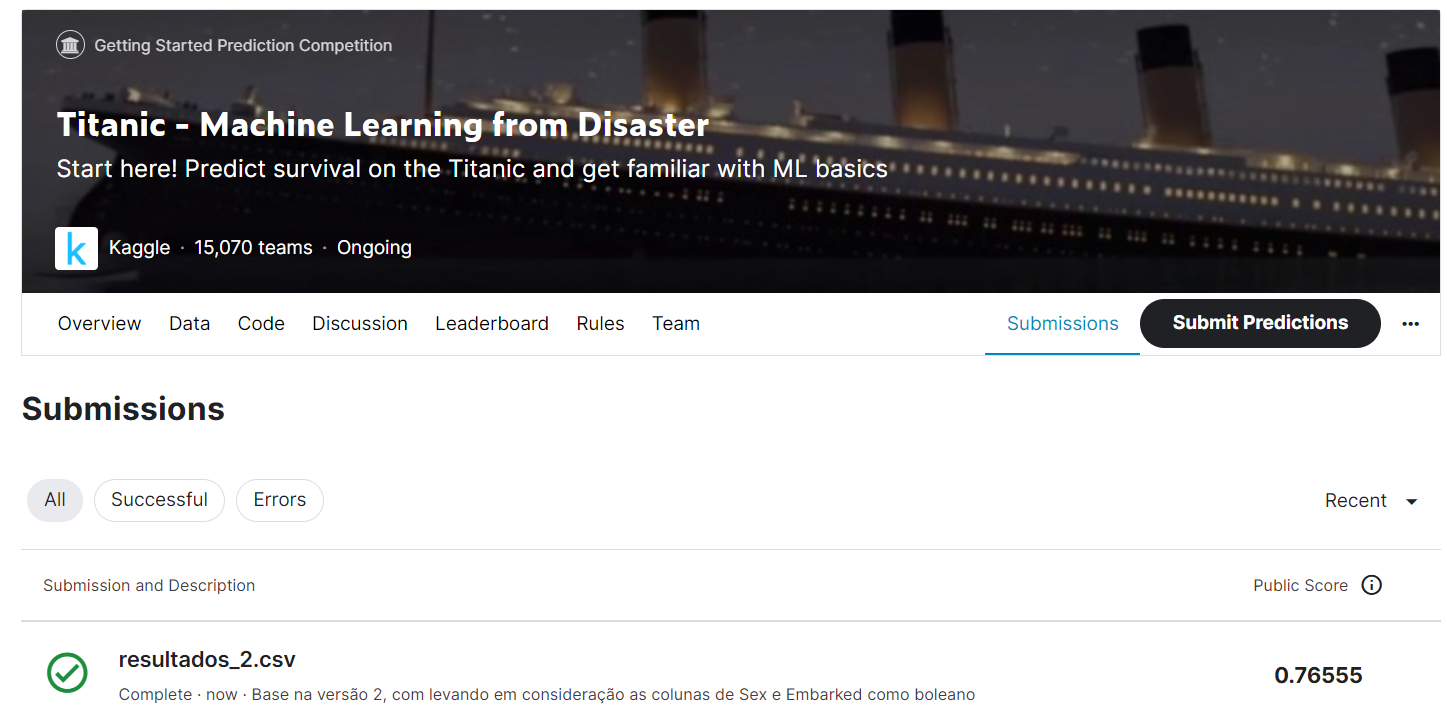